# Recurrent Neural Networks example for Tracking

Set up environment variables

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

os.environ["PYTHONHASHSEED"] = '0'

In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from keras import layers, models
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN

%matplotlib notebook

Using TensorFlow backend.


Redefine the utilities here for now to avoid clashes with the theano stuff in the utils module

Fix the numpy seed for reproducible results

In [3]:
np.random.seed(42)

In [4]:
def reset_view():
    print(80*' ', end='\r')

## Loading the data

Load, concatinate, veryfy, understand datasets

In [5]:
directory = '/inputdata/TkRamp/'
df = pd.DataFrame()

#datasets = [f for f in os.listdir(directory) if f.endswith('.csv')]
datasets = ['dataset100MeV_mu10_24.csv']
for n, dataset in enumerate(datasets):
    if not (dataset.startswith('dataset')): continue
    print('Loading %s ' % dataset, end='\r')
    df = pd.concat([df, pd.read_csv(directory + dataset)], ignore_index=True)

reset_view()
df.head(1)

,event_id,cluster_id,layer,iphi,x,y
0,23000,0,0,161,38.791284,4.029427


In [6]:
# Get events list
events = df.event_id.unique()
# Count the number of tracks
ntrack = df.drop(['layer','iphi','x','y'], axis=1).drop_duplicates().shape[0]

In [7]:
print('There are %d events' % events.shape[0])
print('There are %d total tracks' % ntrack)
print('There are %d total hits' % df.shape[0])
print('There are %d hits on first layer' % df[df.layer == 0].shape[0])
print('There are %d hits on last layer' % df[df.layer == 8].shape[0])
print('Average %g hits per track' % (float(df.shape[0]) / ntrack))

There are 1000 events
There are 9873 total tracks
There are 82336 total hits
There are 9581 hits on first layer
There are 8358 hits on last layer
Average 8.33951 hits per track


## Split dataset

In [8]:
X = df.drop(['cluster_id'], axis=1)
y = df.drop(['layer','iphi','x','y'], axis=1)

from sklearn.model_selection import train_test_split

events_train, events_test = train_test_split(events, test_size=0.2, random_state=42)

## Scoring the assignment

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score

def score_function(y_true, y_pred):
    return adjusted_rand_score(y_true, y_pred)

## Define the model

In [10]:
class TopologyReshape():
    
    def __init__(self):
        self.layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0.05, 0.05])
        self.layer_r = np.array([39, 85, 155, 213, 271, 405, 562, 762, 1000])
        self.num_layers = self.layer_r.shape[0]
        self.max_phi = (2 * np.pi * self.layer_r / self.layer_pitch + 1).astype(np.int)

    def rescale_phi(self, phi, nbin, layer):
        return (phi * float(nbin) / self.max_phi[layer.astype(np.int)]).astype(np.int)

In [11]:
class Clusterer(BaseEstimator):

    def __init__(self, typeof='RNN', phi_bins=100, hidden_layers=50, verbose=False):
        
        self.model = typeof
        self.phi_bins = phi_bins
        self.hidden_layers = hidden_layers
        self.batch_size = 128
        self.num_epoch = 100
        self.verbose = verbose
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'Nadam'
        self.metrics = ['accuracy']
        
        self.topology = TopologyReshape()
        self.model = self.build_model(self.hidden_layers, self.topology.layer_r.shape[0], self.phi_bins)
        
        self.train_X = None
        self.train_y = None
        
    def build_model(self, hidden_layers, length, dim):
        inputs = layers.Input(shape=(length, dim))

        if self.model == 'RNN':
            hidden = layers.SimpleRNN(output_dim=hidden_layers, return_sequences=True, activation='relu')(inputs)
        elif self.model == 'LSTM':
            hidden = layers.LSTM(output_dim=hidden_layers, return_sequences=True, activation='relu')(inputs)
        elif self.model == 'GRU':
            hidden = layers.GRU(output_dim=hidden_layers, return_sequences=True, activation='relu')(inputs)

        outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
        model = models.Model(input=inputs, output=outputs)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        return model

    def score(self, X_test, y_test, timeit=True):        
        rand_inxs = []
        time_meas = []
        test_events = X_test['event_id'].unique()

        for test_event in test_events:
            X_event = X_test[X_test.event_id == test_event]
            y_event = y_test[y_test.event_id == test_event].cluster_id.values

            start = time.time()
            y_predicted = self.predict_single_event(X_event)
            end = time.time()

            score = score_function(y_event, y_predicted)
            rand_inxs.append(score)
            if timeit: time_meas.append(end - start)

        if timeit: return np.mean(rand_inxs), np.mean(time_meas)
        return np.mean(rand_inxs)

    def fit(self, X, y):
        self.prepare_data(X, y)
        if self.verbose: print('Training...               ', end='\r')
        self.history = self.model.fit(self.train_X, self.train_y,
                                      batch_size = self.batch_size,
                                      nb_epoch = self.num_epoch,
                                      verbose=0)
        if self.verbose: print('Model ready!              ', end='\r')

    def predict_single_event(self, X):

        seeds = X[X.layer == 0]

        # Prepare the model inputs
        self.test_input = np.zeros((len(seeds), self.topology.num_layers, self.phi_bins)) 

        # Loop over seeds to prepare
        for i, (index, seed) in enumerate(seeds.iterrows()): #GOOD
            layer_not_first_layer = X[X.layer > 0].layer.astype(np.int)
            iphis_not_first_layer = X[X.layer > 0].iphi_reshaped.astype(np.int)
            
            self.test_input[i, 0, int(seed.iphi_reshaped)] = 1
            self.test_input[i, layer_not_first_layer, iphis_not_first_layer] = 1

        # Run the model prediction
        self.test_pred = self.model.predict(self.test_input)

        # Now we need to loop over all hits and decide which
        # track they belong to
        trkid = np.zeros(len(X))
        for i, (index, hit) in enumerate(X.iterrows()): #GOOD
            lay = hit.layer.astype(np.int)
            phi = hit.iphi_reshaped.astype(np.int)
            
            scores = self.test_pred[:, lay, phi]
            best = np.argmax(scores)
            
            # If the best isn't good enough, it's possible that
            # a track was missing a hit on the first layer.
            # We may be able to improve score by assigning all such
            # tracks to a new class (rather than 'unassigned')
            if scores[best] < 1 / float(self.phi_bins):
                best = scores.shape[0]
                
            trkid[i] = best

        return trkid
    
    def prepare_data(self, X, y):
        if self.train_X is not None: return

        # Gather first-layer hits, which will be the seeds
        seeds = X[X.layer == 0]

        if self.verbose: print('Preparing training data...', end='\r')

        # Training input will contain the seed hit followed by the rest of the event
        self.train_X = np.zeros((len(seeds), self.topology.num_layers, self.phi_bins))

        # Training targets will be images of the individual signal tracks
        self.train_y = np.zeros_like(self.train_X)

        # Loop over training samples to prepare (seeds)
        for i, (index, seed) in enumerate(seeds.iterrows()):
            # Find all the hits from this event on outter layers
            hits_not_first_layer = X[(X.event_id == seed.event_id) & (X.layer > 0)]
            layer_not_first_layer = hits_not_first_layer.layer.astype(np.int)
            iphis_not_first_layer = hits_not_first_layer.iphi_reshaped.astype(np.int)

            # Fill the layers with seed and subsequent hits but there is only seed on inner layer
            self.train_X[i, 0, int(seed.iphi_reshaped)] = 1
            self.train_X[i, layer_not_first_layer, iphis_not_first_layer] = 1

            # Fill target with hits from this particular track
            cluster = y.loc[index].cluster_id.astype(np.int)
            target_prediction_indexes =  (y.event_id == int(seed.event_id)) & (y.cluster_id == cluster)

            target_layer = X[target_prediction_indexes].layer.astype(np.int)
            target_iphis = X[target_prediction_indexes].iphi_reshaped.astype(np.int)
            self.train_y[i, target_layer, target_iphis] = 1                                             

## Cross validating hyperparameters

In [12]:
NUMBER_OF_K_FOLD_SPLITS = 5

In [13]:
from sklearn.model_selection import KFold

def get_cross_validation_score(tracker, events_train):
    cv_scores = []
    cv_timeit = []
    kf = KFold(n_splits=NUMBER_OF_K_FOLD_SPLITS, random_state=42, shuffle=True)
    kf.get_n_splits(events_train)

    for train_index, cv_index in kf.split(events_train):
        kf_events_train, kf_events_cv = events_train[train_index], events_train[cv_index]
        kf_events_train_ix, kf_events_cv_ix = X['event_id'].isin(kf_events_train), X['event_id'].isin(kf_events_cv)

        kf_X_train, kf_y_train, kf_X_cv, kf_y_cv = (X[kf_events_train_ix], y[kf_events_train_ix],
                                                    X[kf_events_cv_ix], y[kf_events_cv_ix])

        tracker.fit(kf_X_train, kf_y_train)
        score, timeit = tracker.score(kf_X_cv, kf_y_cv)
        
        cv_scores.append(score)
        cv_timeit.append(timeit)

    return np.mean(cv_scores), np.mean(cv_timeit)

In [ ]:
cv_columns = ['model', 'hidden_layers', 'phi_bins', 'cv_score', 'cv_timeit']
cv_metrics = pd.DataFrame(columns=cv_columns)

print('Cross-validating...', end='\r')

# Custom grid search
for phi_bins in range(100, 151, 10):
    X['iphi_reshaped'] = X.apply(lambda row: 
                                 TopologyReshape().rescale_phi(row['iphi'], phi_bins, row['layer']),
                                 axis=1)
    for model in ['LSTM', 'GRU']:
        for hidden_layers in range(100, 151, 10):

            tracker = Clusterer(typeof=model, phi_bins=phi_bins, hidden_layers=hidden_layers, verbose=False)
            cv_score, cv_timeit = get_cross_validation_score(tracker, events_train)

            cv_metrics = pd.concat([cv_metrics,
                                    pd.DataFrame([[model, hidden_layers, phi_bins, cv_score, cv_timeit]],
                                                 columns = cv_columns)])

            print('Current model score: %s in %s ms' % (round(cv_score, 3), round(1000 * cv_timeit, 1)), end='\r')

In [ ]:
cv_metrics.sort_values(by='cv_score', ascending=False).head(20)

## Testing

In [12]:
# Select your test parameters
typeof = 'GRU'
hidden_layers = 150
phi_bins = 150
tracker = Clusterer(typeof=typeof, hidden_layers=hidden_layers, phi_bins=phi_bins, verbose=True)
X['iphi_reshaped'] = X.apply(lambda row: TopologyReshape().rescale_phi(row['iphi'], phi_bins, row['layer']), axis=1)

In [13]:
train_selector = X['event_id'].isin(events_train)
X_train, y_train = X[train_selector], y[train_selector]

In [14]:
tracker.fit(X_train, y_train)

In [15]:
# Test on random event
ievent = X.sample(n=1).iloc[0].event_id

X_event = X[X.event_id == ievent]
y_predicted = tracker.predict_single_event(X_event)
y_test_event = y[y.event_id==ievent].values

print("For event number %s The Rand Index is %s." % (ievent, score_function(y_test_event[:, 1], y_predicted)))

For event number 23914.0 The Rand Index is 0.727966518956.


In [16]:
df['predicted_cluster'] = np.nan

In [18]:
events = df['event_id'].unique()

for event in events:
    X_event = X[X['event_id'] == event].loc[:, ['layer', 'iphi_reshaped']]
    y_predicted = tracker.predict_single_event(X_event)
    y_test_event = y[y['event_id'] == event].values

    # Feed back to dataframe
    df.loc[df['event_id'] == event, "predicted_cluster"] = y_predicted

In [19]:
rand_inxs = []

for event in events_test:
    rand_inxs.append(score_function(df[df['event_id'] == event].cluster_id, 
                                    df[df['event_id'] == event].predicted_cluster))

worst_prediction = events[rand_inxs.index(min(rand_inxs))]
best_prediction = events[rand_inxs.index(max(rand_inxs))]

print("The average Rand Index is %s. Worst prediction for event %s; best for %s"
      % (round(np.mean(rand_inxs), 2), worst_prediction, best_prediction))

The average Rand Index is 0.61. Worst prediction for event 23179; best for 23002


## Snooping

Visualize the prediction for the worst event in the format that the model sees.

In [20]:
def display(pixelx, pixely, tracks, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.subplot(aspect='equal')
    for layer,r in enumerate([39, 85, 155, 213, 271, 405, 562, 762, 1000]):
        plt.gcf().gca().add_artist(
            plt.Circle((0, 0), r,color='b',
                       fill=False ,linestyle='--'))
    for itrack in np.unique(tracks):
        if itrack >= 0:
            hits_track = (tracks == itrack)
            plt.plot(pixelx[hits_track],pixely[hits_track],
                     marker='o', linestyle='none',
                     label='track %d'%itrack)
    itrack = -1
    hits_track = (tracks == itrack)
    plt.plot(pixelx[hits_track], pixely[hits_track], 
             color='black', marker='o',
             fillstyle='none', linestyle='none',
             label='not associated')
    plt.xlim((-1100,1100))
    plt.ylim((-1100,1100))
    plt.legend(loc=(1.1,0.2), numpoints=1)
    plt.show()

Worst prediction


<IPython.core.display.Javascript object>


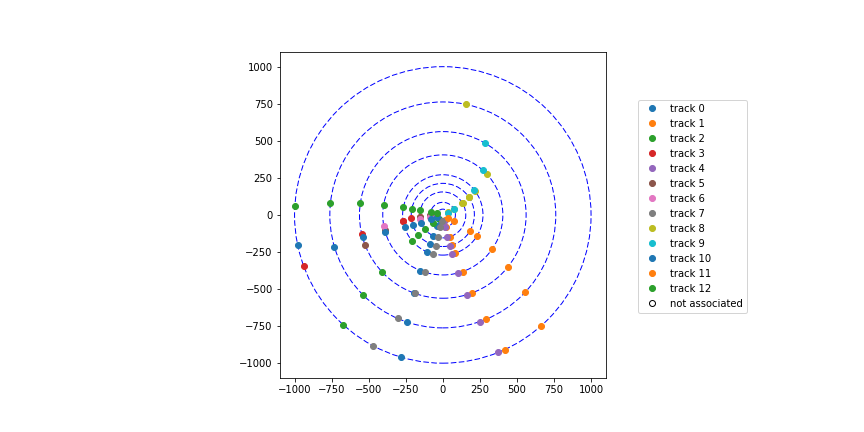

<IPython.core.display.Javascript object>


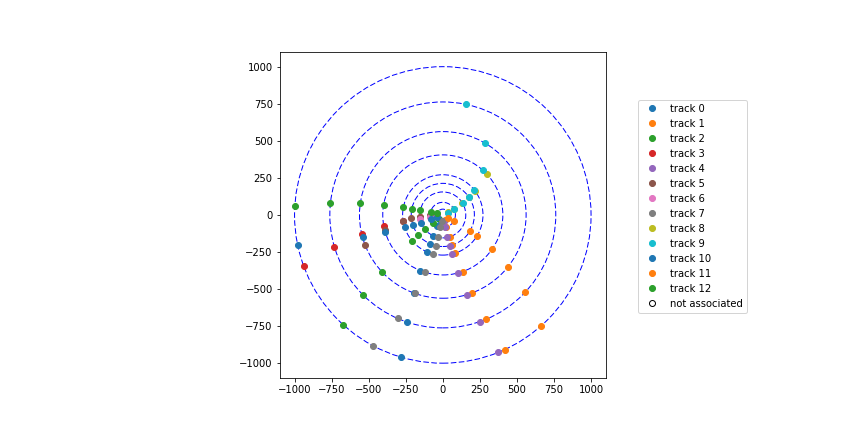

In [21]:
print("Worst prediction")
e = df[df.event_id == worst_prediction]
display(e.x, e.y, e.predicted_cluster, figsize=(12,6))
display(e.x, e.y, e.cluster_id, figsize=(12,6))